In this notebook we will add diffusion in addition to reactions. We will first study the simplest possible chemical reaction set:

$$
A \overset{k}{\rightarrow} B
$$

we will consider a flat geometry where we assume the concentration is constant in all directions except one (giving us a one dimensional system with respect to space). Following the serialization format we introduced earlier:

In [1]:
reactions = [
    ('k', {'A': 1}, {'B': 1, 'A': -1}),
]
names, params = 'A B'.split(), ['k']

The diffusion follows [Fick's law of diffusion](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion):

$$
\frac{\partial c_i}{\partial t} = D \frac{\partial^2 c_i}{\partial x}
$$

where $t$ is time, $c_i$ is the local concentration of species $i$, $x$ is the spatial variable and $D$ the diffusion constant. Note that a pure diffusion process is identical to the perhaps more well known [heat equation](https://en.wikipedia.org/wiki/Heat_equation). We will, however, also consider contributions ($r_i$) from chemical reactions:

$$
\frac{\partial c_i}{\partial t} = D \frac{\partial^2 c_i}{\partial x} + r_i
$$

We will set the diffusion constant ($m^2/s$ in SI units) equal for our two species in this example: 

In [2]:
D = [8e-9, 8e-9]  # He diffusion constant in water at room temperature

We will solve the [partial differential equation](https://en.wikipedia.org/wiki/Partial_differential_equation) (PDE) using [method of lines](https://en.wikipedia.org/wiki/Method_of_lines). We discretize space into a series of bins (lines), in each of these bins we calculate the contribution of chemical reactions to the rate of change, and then add the diffusion contribution based on a [finite difference](https://en.wikipedia.org/wiki/Finite_difference#Higher-order_differences) estimate of the second derivative.

SymPy contains an algorithm to calculate finite difference weights:

In [3]:
import sympy as sym
x, h = sym.symbols('x h')
d2fdx2 = sym.Function('f')(x).diff(x, 2)
d2fdx2.as_finite_difference([x-h, x, x+h], x).factor()

(-2*f(x) + f(-h + x) + f(h + x))/h**2

In this case, we are dealing with an equidistant grid and you may very well recognize this result from standard text books (it is actually quite easy to derive from the definition of the derivative).

The number of dependent variables in our ODE system is then the number of species multiplied by the number of bins. There is no need to create that many symbols, instead we rely on writing an outer loop calculating the local reactions rates. We create a new subclass of our ``ODEsys`` class from earlier to do this:

In [4]:
# %load ../scipy2017codegen/odesys_diffusion.py
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from scipy2017codegen.odesys import ODEsys


class MOLsys(ODEsys):
    """ System of ODEs based on method of lines on the interval x = [0, x_end] """

    def __init__(self, *args, **kwargs):
        self.x_end = kwargs.pop('x_end')
        self.n_lines = kwargs.pop('n_lines')
        self.D = kwargs.pop('D')
        self.dx = self.x_end / self.n_lines
        super(MOLsys, self).__init__(*args, **kwargs)

    def f_eval(self, y, t, *params):
        f_out = np.empty(self.ny*self.n_lines)
        for i in range(self.n_lines):
            slc = slice(i*self.ny, (i+1)*self.ny)
            y_bis = self.second_derivatives_spatial(i, y, f_out[slc])
            f_out[slc] *= self.D
            f_out[slc] += self.lambdified_f(*chain(y[slc], params))
        return f_out

    def central_reference_bin(self, i):
        return np.clip(i, 1, self.ny - 2)

    def j_eval(self, y, t, *params):
        j_out = np.zeros((self.ny*self.n_lines, self.ny*self.n_lines))  # dense matrix
        for i in range(self.n_lines):
            slc = slice(i*self.ny, (i+1)*self.ny)
            j_out[slc, slc] = self.lambdified_j(*chain(y[slc], params))
            k = self.central_reference_bin(i)
            for j in range(self.ny):
                j_out[i*self.ny + j, (k-1)*self.ny + j] +=    self.D[j]/self.dx**2
                j_out[i*self.ny + j, (k  )*self.ny + j] += -2*self.D[j]/self.dx**2
                j_out[i*self.ny + j, (k+1)*self.ny + j] +=    self.D[j]/self.dx**2
        return j_out

    def second_derivatives_spatial(self, i, y, out):
        k = self.central_reference_bin(i)
        for j in range(self.ny):
            left = y[(k-1)*self.ny + j]
            cent = y[(k  )*self.ny + j]
            rght = y[(k+1)*self.ny + j]
            out[j] = (left - 2*cent + rght)/self.dx**2

    def integrate(self, tout, y0, params=(), **kwargs):
        y0 = np.array(np.vstack(y0).T.flat)
        yout, info = super(MOLsys, self).integrate(tout, y0, params, **kwargs)
        return yout.reshape((tout.size, self.n_lines, self.ny)).transpose((0, 2, 1)), info

    def x_centers(self):
        return np.linspace(self.dx/2, self.x_end - self.dx/2, self.n_lines)

    def plot_result(self, tout, yout, info=None, ax=None):
        ax = ax or plt.subplot(1, 1, 1)
        x_lines = self.x_centers()
        for i, t in enumerate(tout):
            for j in range(self.ny):
                c = [0.0, 0.0, 0.0]
                c[j] = t/tout[-1]
                plt.plot(x_lines, yout[i, j, :], color=c)
        self.print_info(info)


In [5]:
from scipy2017codegen.chem import mk_rsys
molsys = mk_rsys(MOLsys, reactions, names, params, x_end=0.01, n_lines=50, D=D)
xc = molsys.x_centers()
xm = molsys.x_end/2
A0 = np.exp(-1e6*(xc-xm)**2)
B0 = np.zeros_like(A0)

In [6]:
tout = np.linspace(0, 30, 40)
yout, info = molsys.integrate(tout, [A0, B0], [0.00123])
yout.shape

(40, 2, 50)

The rhs was evaluated 123 times and the jacobian 0 times


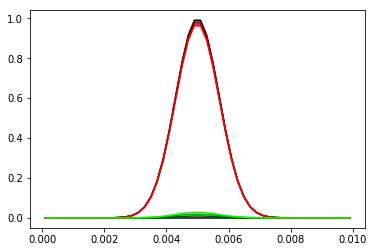

In [7]:
%matplotlib inline
molsys.plot_result(tout[::10], yout[::10, ...], info)